<a href="https://colab.research.google.com/github/mattshu0410/Peripheral-Blood-Deep-Learning/blob/main/YOLOv5_Crop_Out_WBC_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import PIL
import numpy as np
import os
import ast
import matplotlib.pyplot as plt

# Crop out BCCD WBC w/ YOLOv5s

This section aims to cut out all WBC out of the BCCD dataset using YOLOv5. This can then be categorised into WBC types by a hematologist. This will then be used as an independent test set to assess the effectiveness of the WBC classifier trained on the WBC dataset from Acevedo et. al.

In [ ]:
# Gathers BCCD dataset
!git clone 'https://github.com/Shenggan/BCCD_Dataset.git'

In [ ]:
# Install dependencies for YOLOv5
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

In [ ]:
# Clones repository containing models from Git Repo: https://github.com/ultralytics/yolov5
!git clone  'https://github.com/ultralytics/yolov5.git'

In [ ]:
# Runs YOLOv5s and stores all annotations as text
!python /content/yolov5/detect.py --source /content/BCCD_Dataset/BCCD/JPEGImages --weights "/content/4-01-2022-artemis.pt" --save-txt 

In [ ]:
# Function that cropps out all white blood cells for a particular image, takes a list of dictionaries i.e. records
# e.g. [{'category_id': 2, 'x': 0.414062, 'y': 0.459375, 'w': 0.28125, 'h': 0.385417, 'image_id': 'BloodImage_00300'}, {...}, {...}]
def image_crop(bbox_dict, export_path):
  image_id = bbox_dict[0]['image_id']
  image = PIL.Image.open(f'/content/BCCD_Dataset/BCCD/JPEGImages/{image_id}.jpg')
  for i, bbox in enumerate(bbox_dict):
    image_w, image_h = image.size
    image_array = np.array(image)
    x,y,w,h = int(bbox_dict[i]['x']*image_w), int(bbox_dict[i]['y']*image_h), int(bbox_dict[i]['w']*image_w), int(bbox_dict[i]['h']*image_h)
    w=h=max(w,h) # We want square crops that include the whole WBC
    x_i, x_f, y_i, y_f  = x-w/2, x+w/2, y-h/2, y+h/2
    # If a square bounding box reaches outside the image, this will shift the limits back into the image
    if x_i<0:
      x_f = x_f-x_i
      x_i = 0
    if x_f>image_w:
      x_i = x_i-(x_f-image_w)
      x_f = image_w
    if y_i<0:
      y_f = y_f-y_i
      y_i = 0
    if y_f>image_h:
      y_i = y_i-(y_f-image_h)
      y_f = image_h
    crop_img=image_array[int(y_i):int(y_f), int(x_i):int(x_f)]
    try:
      im = PIL.Image.fromarray(crop_img)
      im = im.resize((224,224))
      im.save(os.path.join(export_path, f'{image_id}_{i}.png')) # File naming is {image_id} + {i}th WBC cropped
    except:
      print(f'{image_id} was omitted')



In [ ]:

label_path = '/content/yolov5/runs/detect/exp/labels/'
export_path = '/content/BCCD_cropped_wbc/'
wbc=[]

# Extracts all bounding boxes that are white blood cells
for filename in os.listdir(label_path):
  with open(os.path.join(label_path, filename)) as file:
    # Creates a dataframe with all the bounding boxes found in this image
    df = pd.read_csv(file, 
                     delim_whitespace=True, 
                     header = None,
                     names =['category_id', 'x', 'y', 'w', 'h'])
    df['image_id'] = filename.rstrip('.txt')
    # Adds to a list of dictionaries containing all WBC across all images
    wbc += df[df.category_id == 2].to_dict('records')


In [ ]:
# Dataframe of image_id and 
wbc_df = pd.DataFrame.from_dict(wbc)

# Runs crop on each image
for image_id in set(wbc_df['image_id'].tolist()):
  bbox_dict = wbc_df[wbc_df['image_id']==image_id].to_dict('records')
  image_crop(bbox_dict)



In [ ]:
!zip -r '/content/BCCD_cropped_wbc.zip' '/content/BCCD_cropped_wbc'

# Crop out Acevedo et. al. dataset WBC w/ YOLOv5s

The following section aims to crop out all WBC from the data published by Acevedo et. al.

Dataset: https://www.sciencedirect.com/science/article/pii/S2352340920303681



In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/PBC_dataset_normal_DIB.zip'

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/4-01-2022-artemis.pt' '/content'

In [ ]:
# Runs YOLOv5s and stores all annotations as text
wbc_type = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
for wbc in wbc_type:
  !python /content/yolov5/detect.py --source /content/PBC_dataset_normal_DIB/{wbc} --weights "/content/4-01-2022-artemis.pt" --save-txt --project runs/detect/{wbc} --classes 2 --nosave --exist-ok

## Cropping out Images (Size not Considered)

In many cases the YOLOv5s object detection model manages to pick out WBC on the border of the image. However, given we are dealing with a clean dataset where each image's label corresponds to a single cell that is largest and closest to the centre, we will use this as our rule for choosing the primary bounding box to cut out. If both conditions are not met by a single bounding box we will call for a manual check.

In [ ]:
# Crops the main white blood cell from the image based on given bounding boxes from YOLOV5s
def single_crop(bbox_dict, wbc):
  image_id = bbox_dict[0]['image_id']
  image = PIL.Image.open(f'/content/PBC_dataset_normal_DIB/{wbc}/{image_id}.jpg')
  image_w, image_h = image.size
  image_array = np.array(image)
  main_bbox = {}
  # YOLOV5s model detects multiple bounding boxes.
  # This automatically chooses the main bounding box to be one with the largest size and closest to the centre
  # It will throw a warning when either of these conditions are not met but will choose closest to the centre
  if len(bbox_dict)==1:
    i=0
    x,y,w,h = int(bbox_dict[i]['x']*image_w), int(bbox_dict[i]['y']*image_h), int(bbox_dict[i]['w']*image_w), int(bbox_dict[i]['h']*image_h)
    main_bbox = {
          'x': x,
          'y': y,
          'w': w,
          'h': h
      }
  else:
    bboxes = {}
    for i, bbox in enumerate(bbox_dict):
      x,y,w,h = int(bbox_dict[i]['x']*image_w), int(bbox_dict[i]['y']*image_h), int(bbox_dict[i]['w']*image_w), int(bbox_dict[i]['h']*image_h)
      bboxes[i] = {
          'area': x*y,
          'x_offset': abs(x-image_w/2),
          'y_offset': abs(y-image_h/2),
          'bbox': str({'x': x,'y': y,'w': w,'h': h})
      }
    bboxes_df = pd.DataFrame.from_dict(bboxes, orient='index')
    if (bboxes_df['area'].idxmax() == bboxes_df['x_offset'].idxmin() == bboxes_df['y_offset'].idxmin()):
      i = bboxes_df['area'].idxmax()
      main_bbox = ast.literal_eval(bboxes_df.iloc[[i]]['bbox'].values[0])
    elif (bboxes_df['x_offset'].idxmin() == bboxes_df['y_offset'].idxmin()):
      i = bboxes_df['x_offset'].idxmin()
      main_bbox = ast.literal_eval(bboxes_df.iloc[[i]]['bbox'].values[0])
      print(f'{image_id} is a little ambiguous for which is the main WBC. Main bbox chosen based on centering to be:')
      print(main_bbox)
      omit_count[wbc]['ambiguous']+=1
    else:
      print(f'{image_id} is omitted. This is too ambiguous to determine.')
      omit_count[wbc]['omitted']+=1
      return None

  # This sets the x bounds and y bounds for cropping
  x,y,w,h = int(main_bbox['x']), int(main_bbox['y']), int(main_bbox['w']), int(main_bbox['h'])
  w=h=max(w,h) # We want square crops that include the whole WBC
  x_i, x_f, y_i, y_f  = x-w/2, x+w/2, y-h/2, y+h/2

  # If a square bounding box reaches outside the image, this will shift the limits back into the image
  if x_i<0:
    x_f = x_f-x_i
    x_i = 0
  if x_f>image_w:
    x_i = x_i-(x_f-image_w)
    x_f = image_w
  if y_i<0:
    y_f = y_f-y_i
    y_i = 0
  if y_f>image_h:
    y_i = y_i-(y_f-image_h)
    y_f = image_h

  # Crops the image with final dimensions
  crop_img=image_array[int(y_i):int(y_f), int(x_i):int(x_f)]
  try:
    im = PIL.Image.fromarray(crop_img)
    im = im.resize((224,224))
    return im
  except:
    print(f'{image_id} was omitted, there was an error cropping.')


In [ ]:
wbc_type = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
root = '/content/runs/detect/'
# For each white blood cell

omit_count = {
    'basophil': {
        'ambiguous': 0,
        'omitted': 0
        },
    'eosinophil':{
        'ambiguous': 0,
        'omitted': 0
        },
    'erythroblast':{
        'ambiguous': 0,
        'omitted': 0
        },
    'ig':{
        'ambiguous': 0,
        'omitted': 0
        },
    'lymphocyte':{
        'ambiguous': 0,
        'omitted': 0
        },
    'monocyte':{
        'ambiguous': 0,
        'omitted': 0
        },
    'neutrophil':{
        'ambiguous': 0,
        'omitted': 0
        },
    'platelet':{
        'ambiguous': 0,
        'omitted': 0
        },
}

for wbc in wbc_type:
  os.makedirs(f'/content/runs/cropped/{wbc}')
  path = os.path.join(root, wbc+"/exp/labels/")
  for filename in os.listdir(path):
    with open(os.path.join(root, wbc+"/exp/labels/", filename)) as file:
      df = pd.read_csv(file, 
                       delim_whitespace=True, 
                       header = None,
                       names =['category_id', 'x', 'y', 'w', 'h'])
      image_id = filename.rstrip('.txt')
      df['image_id'] = image_id
      bbox_dict = df.to_dict('records')
      im = single_crop(bbox_dict, wbc)
      if im:
        im.save(f'/content/runs/cropped/{wbc}/{image_id}.png') # File naming is {image_id}
      else:
        print(f'This image was not saved')

In [ ]:
print(pd.DataFrame.from_dict(omit_count).to_markdown())

In [ ]:
!zip -r '/content/runs.zip' '/content/runs'

## Cropping out Images (Size Considered)

Only using images that have 1 WBC inside to avoid ambiguity. 

In [ ]:
rmtree('/content/runs/cropped')

In [ ]:
wbc_type = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
root = '/content/runs/detect/'
# For each white blood cell

total_wbc = []
counter = 0
for wbc in wbc_type:
  os.makedirs(f'/content/runs/cropped/{wbc}')
  path = os.path.join(root, wbc+"/exp/labels/")
  for filename in os.listdir(path):
    with open(os.path.join(root, wbc+"/exp/labels/", filename)) as file:
      df = pd.read_csv(file, 
                       delim_whitespace=True, 
                       header = None,
                       names =['category_id', 'x', 'y', 'w', 'h'])
      # Pick only detected cells that are WBC
      wbc_df = df[df.category_id == 2].copy()
      image_id = filename.rstrip('.txt')
      wbc_df['image_id'] = image_id
      wbc_df['wbc_type'] = wbc
      bbox_dict = wbc_df.to_dict('records')
      # Omit images that have more than one WBC in it
      if wbc_df.shape[0] == 1:
        total_wbc = total_wbc + bbox_dict
      else:
        counter += 1

Find maximum bounding box. It seems like al

In [ ]:
total_wbc_df = pd.DataFrame(total_wbc)
total_wbc_df['x'].idxmax()

1750

In [ ]:
total_wbc_df.iloc[1750]

category_id             2
x                0.884722
y                0.333333
w                   0.225
h                0.275482
image_id        EO_664204
wbc_type       eosinophil
Name: 1750, dtype: object

In [ ]:
total_wbc_df['y'].idxmax()

10289

In [ ]:
total_wbc_df.iloc[10289]

category_id            2
x               0.368056
y               0.966942
w               0.302778
h               0.066116
image_id       MO_363879
wbc_type        monocyte
Name: 10289, dtype: object

In [ ]:
for i, bbox_dict in enumerate(total_wbc):
  image_id = total_wbc[i]['image_id']
  wbc = total_wbc[i]['wbc_type']
  image = PIL.Image.open(f'/content/PBC_dataset_normal_DIB/{wbc}/{image_id}.jpg')
  image_array = np.array(image)
  crop_img = image_array[0:360, 0:360]
  try:
    im = PIL.Image.fromarray(crop_img)
    im = im.resize((224,224))
  except:
    print(f'{image_id} was omitted, there was an error cropping.')
  if im:
    im.save(f'/content/runs/PBC_cropped/{wbc}/{image_id}.png') # File naming is {image_id}
  else:
    print(f'This image was not saved')

In [ ]:
!zip -r '/content/PBC_dataset_nomal_DIB_cropped_224_size_considered.zip' '/content/runs/cropped'

## Determine the average size of RBC within the dataset.

We use object detection YOLOv5 inference to detect all RBC within the Acevedo dataset. We then take the root mean of the sum of areas of RBC within the dataset.

In [ ]:
# Runs YOLOv5s and stores all annotations as text
wbc_type = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
for wbc in wbc_type:
  !python /content/yolov5/detect.py --source /content/PBC_dataset_normal_DIB/{wbc} --weights "/content/4-01-2022-artemis.pt" --save-txt --project runs/detect/{wbc} --classes 1 --nosave --exist-ok

In [ ]:
import pandas as pd
import math
rbc_sizes_acevedo = []
root = '/content/runs/detect'

image_w = 360
image_h = 363

for wbc in wbc_type:
  path = os.path.join(root, wbc+"/exp/labels/")
  for filename in os.listdir(path):
    with open(os.path.join(root, wbc+"/exp/labels/", filename)) as file:
      df = pd.read_csv(file, 
                       delim_whitespace=True, 
                       header = None,
                       names =['category_id', 'x', 'y', 'w', 'h'])
      rbc_df = df.loc[df['category_id'] == 1].copy()
      rbc_df["area"] = rbc_df["w"] * image_w * rbc_df["h"] * image_h
      rbc_sizes_acevedo = rbc_sizes_acevedo + rbc_df["area"].tolist()
      

In [ ]:
sum(rbc_sizes_acevedo)

1209201983.423902

In [ ]:
r1 = math.sqrt(sum(rbc_sizes_acevedo)/len(rbc_sizes_acevedo))

In [ ]:
r1

68.78754078932712

It seems like the RBC size distribution is relatively tight, indicating the images in Acevedo dataset are likely all the same in magnification.

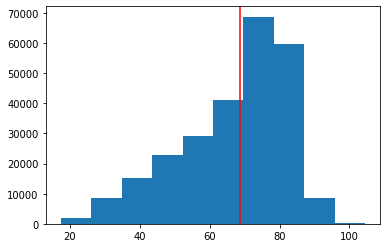

In [ ]:
plt.hist(np.sqrt(rbc_sizes_acevedo))
plt.axvline(r1, color='r')

## Resizing

**DO NOT RUN CODE**

This was code that converted all the images to 224 size however that has now been implemented during cropping above.

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/BCCD_cropped_wbc_classified_test_set.zip'

In [ ]:
import os
from PIL import Image
from tqdm import tqdm
search_directory = '/content/BCCD_cropped_wbc_classified_test_set'
image_files = []
for root, dirs, files in os.walk(search_directory):
  for file in tqdm(files):
    if (file.endswith(".png") or file.endswith('.PNG')):
      im = Image.open(os.path.join(root, file))
      im_resized = im.resize((224,224))
      im_resized.save(os.path.join(root, file))


0it [00:00, ?it/s]
100%|██████████| 21/21 [00:00<00:00, 30.57it/s]


In [ ]:
!zip -r '/content/BCCD_cropped_wbc_classified_test_set.zip' '/content/BCCD_cropped_wbc_classified_test_set'

In [ ]:
!cp /content/PBC_dataset_nomal_DIB_cropped_224_size_considered.zip /content/drive/MyDrive/Colab\ Notebooks

# Crop out WBC from Blood Films

In [ ]:
# Runs YOLOv5s and stores all annotations as text
source_path = '/content/Blood_Film_Cases'
save_path = '/content/yolov5/runs/detect/'
cases = next(os.walk(source_path))[1]

#for root, path, files in os.walk(image_path):
#  print(root, path, file)
for case in cases:
  image_path = os.path.join(source_path, case, '40x')
  label_path = os.path.join(save_path, case)
  !python /content/yolov5/detect.py --source {image_path} --weights "/content/4-01-2022-artemis.pt" --save-txt --project {label_path} --classes 2 --nosave --exist-ok

# Crop out WBC from RPA Blood Films


## Determine the average size of RBC within the dataset.

Here we are finding the average size of RBC in these custom RPA blood films (R2). Earlier we found the average size of RBC in the training data (R1). Using both, we can figure out the ratio of RBC sizes i.e. R2/R1. 

In [ ]:
from shutil import rmtree
rmtree('/content/Output')

In [ ]:
!unzip  '/content/drive/MyDrive/Colab Notebooks/RPA Blood Film Labels (Crude Labels).zip'

In [ ]:
file_path = '/content/RPA Blood Film Labels (Crude Labels)'

rbc_sizes_RPA = []

image_w = 2448
image_h = 1920

for filename in os.listdir(file_path):
  with open(os.path.join(file_path, filename)) as file:
    df = pd.read_csv(file, 
      delim_whitespace=True, 
      header = None,
      names =['category_id', 'x', 'y', 'w', 'h'])
    rbc_df = df.loc[df['category_id'] == 2].copy()
    rbc_df["area"] = rbc_df["w"] * image_w * rbc_df["h"] * image_h
    rbc_sizes_RPA = rbc_sizes_RPA + rbc_df["area"].tolist()

In [ ]:
sum(rbc_sizes_RPA)

22570615.887289412

In [ ]:
r2 = math.sqrt(sum(rbc_sizes_RPA)/len(rbc_sizes_RPA))

In [ ]:
r2

137.6625545113873

It seems like the RBC size distribution is relatively tight, indicating the images in RPA dataset are likely all the same in magnification.

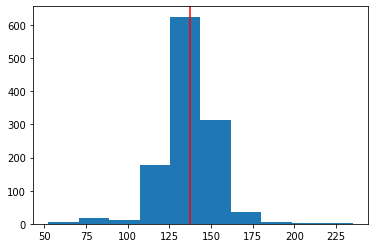

In [ ]:
plt.hist(np.sqrt(rbc_sizes_RPA))
plt.axvline(r2, color='r')

Ratio of RBC Sizes

In [ ]:
rbc_ratio = r2/r1
rbc_ratio

2.0012716391911867

## Cropping out Images (Size Considered)

The original cropping size for images used in training the classifier was 360px by 360 px. The r1 i.e. average root-mean RBC Area in Acevedo dataset is `r1 = 0.1902852917455713` 

In [ ]:
crop_length = math.sqrt(rbc_ratio*360*360)

In [ ]:
crop_length

509.27870998027964

Manually modify to 350 to fit size.

In [ ]:
crop_length = 350

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/RPA Blood Film Labels (Specific Labels).zip'

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/RPA Blood Film Images.zip'

In [ ]:
rmtree('/content/runs/RPA_cropped')

In [ ]:
label_file_path = '/content/RPA Blood Film Labels (Specific Labels)'
image_file_path = '/content/RPA Blood Film Images'

wbc_names = {
    0: 'platelet',
    1: 'rbc',
    2: 'neutrophil',
    3: 'eosinophil',
    4: 'lymphocyte',
    5: 'monocyte',
    6: 'basophil',
    7: 'myelocyte',
    8: 'promyelocyte',
    9: 'blast',
    10: 'erythroblast'
}

total_wbc = []

os.makedirs('/content/runs/RPA_cropped/')
for value in wbc_names.values():
  os.makedirs(f'/content/runs/RPA_cropped/{value}')

for filename in os.listdir(label_file_path):
  with open(os.path.join(label_file_path, filename)) as file:
    df = pd.read_csv(file, 
      delim_whitespace=True, 
      header = None,
      names =['category_id', 'x', 'y', 'w', 'h'])
    image_id = filename.rstrip('.txt')
    wbc_df = df.loc[df['category_id'] != 1].copy()
    bbox_dict = wbc_df.to_dict('records')


    # Open image to crop
    image = PIL.Image.open(os.path.join(image_file_path, f'{image_id}.jpg'))
    image_w, image_h = image.size
    image_array = np.array(image)

    for i, bbox in enumerate(bbox_dict):
      x, y = int(bbox['x']*image_w), int(bbox['y']*image_h)
      category_id = bbox['category_id']
      # Crop using adjusted crop size based on RBC ratio
      x_i, x_f, y_i, y_f  = x-crop_length/2, x+crop_length/2, y-crop_length/2, y+crop_length/2
      crop_img = image_array[int(y_i):int(y_f), int(x_i):int(x_f)]
      try:
        im = PIL.Image.fromarray(crop_img)
        im = im.resize((224,224))
        if im:
            im.save(f'/content/runs/RPA_cropped/{wbc_names[category_id]}/{image_id}_{i}.png') # File naming is {image_id}_{i} where i is WBC in image
      except:
        print(f'Can\'t crop WBC {i} from image with image_id {image_id}')

In [ ]:
!zip -r '/content/RPA_cropped_wbc_classified.zip' '/content/runs/RPA_cropped'

In [ ]:
!cp /content/RPA_cropped_wbc_classified.zip /content/drive/MyDrive/Colab\ Notebooks